In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
import math
import mne
import matplotlib.pyplot as plt
import pickle
import random
import warnings
from scipy.fft import rfft, rfftfreq
from sklearn import preprocessing, svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV


from data_extraction import  Extract_data_from_subject
from data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time

np.random.seed(23)

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning ) 

# Notes on Data Extraction:

### Parameters
> - Sampling Rate (fs) = 256
> - data type: eeg, exg or baseline
> - T-start: start of window (t=0: focus, t=0.5: arrow, t=1: cue (thinking), t=3.5: rest t=4.5: end)
> - T-end: close of window
> - N_S: subject number (1 through 10)
> - N_B: Session (batch) number

### Extract_subject_from_BDF(root_dir,N_S,N_B):

> Loads raw data for subject and session. Takes the directory pointing to folder containing all recordings
> and preprocessed files, subject number and session/batch number, and returns (raw data, subject number)

### Extract_data_from_subject(root_dir,N_S,datatype):

> Loads all blocks for one subject and stacks results. Takes the directory, calls the file for specified data 
> under the specified subject, and stacks all samples into one object. Also calls the labels. Returns (X,Y): 
> object with stacked trials/samples, and object with correlated labels.

### Extract_block_data_from_subject(root_dir,N_S,datatype,N_B):

> Does the same as above Extract_data_from_subject, but for a specified N_B (batch or session number).
> returns (data samples, labels)

### Extract_report(root_dir,N_B,N_S):

> Pulls report with information regarding the given subject and session. Includes subject age, gender,
> length of recording, count of correct and incorrect answer to control questions, position of contaminated
> trials, mean power for EXG channels 7 & 8, and mean and STD for EXG 7 & 8 baseline recordings.

### Extract_TFR(TRF_dir, Cond, Class, TFR_method , TRF_type):

> Returns Time-Frequency Representation of specified condition and class. 
>
> *Note: location of TRF data unclear, not likely to use in scope of project.*

### Extract_data_multisubject(root_dir, N_S_list, datatype='EEG'):

> Creates a stacked object of all sessions for all listed subjects and returns the stacked trials/samples
> along with a stack of the corresponding labels.

### load_events(root_dir,N_S,N_B):

> Loads the events file to gather the label(s) for dataset using root directory, subject, and batch number.

### Select_time_window(X,t_start=1, t_end=2.5, fs=256):

> Cuts samples to desired time window.

### Transform_for_classificator (X, Y, Classes, Conditions):

> Pulls from the extracted dataset the trials and labels that correspond to the conditions and classes that
> will be used for training and/or testing.


In [3]:
root_dir = '/kaggle/input/inner-speech-recognition/inner-speech-recognition'

In [4]:
N_S = 1
datatype = 'eeg'
Tstart = 1.5
Tend = 3.5
fs = 256

samples,labels = Extract_data_from_subject(root_dir,N_S,datatype)

In [5]:
#Cut time window from 1.5 to 3.5 seconds after stimulus
samples_2 = Select_time_window(X = samples, t_start = Tstart, t_end = Tend, fs = fs)

In [6]:
#Extract only samples from Inner Condition, all four directions
X_2, Y_2 = Transform_for_classificator(X = samples_2, Y = labels, Classes = [['ALL']], Conditions = [['Inner']])
#Convert to microvolts
X_2 = X_2 * (10**6)

Now that we have our data imported, windows sliced and classes and conditions picked, we need to do some final adjustments such as label encoding.

In [7]:
#We are interested in identifying the direction of the trial, given in the second column of the labels. we will one-hot encode for ML
data_labels= Y_2[:,1]
#For SVM, we will not one-hot encode the labels
# Y_2 = pd.get_dummies(Y_2)
trials_dict = {0:'up',
               1:'down',
               2:'right',
               3:'left'}
trial_labels = np.array([trials_dict[direction] for direction in data_labels])
trial_labels.shape

(200,)

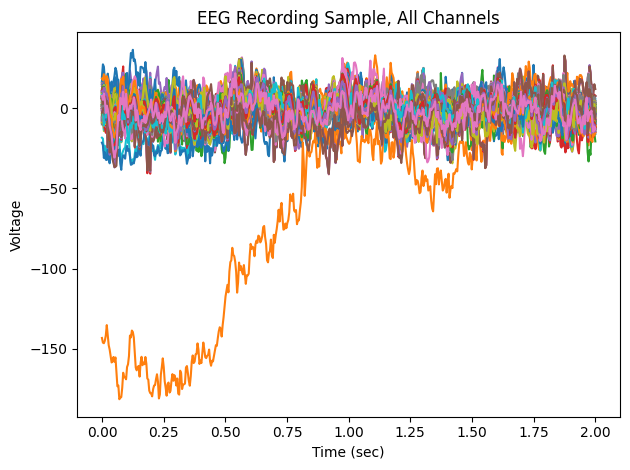

In [8]:
plt.figure()
for i in range(X_2.shape[1]-1):
    plt.plot(np.linspace(0,2,512), X_2[1,i,:]);
plt.xlabel('Time (sec)')
plt.ylabel('Voltage')
plt.title('EEG Recording Sample, All Channels')
plt.tight_layout()
plt.show()

# FFT

We will convert the signal into a power spectral density plot and select windows of frequencies that may be significant to our model

In [ ]:
#Count the number of samples in each recording, it should be 2sec x 256Hz = 512
#N = X_2.shape[2]
#N

In [ ]:
#Run a FFT on the each channel of each recording, and get frequencies
#samples_fft = rfft(X_2)
#samples_freq = rfftfreq(N, 1/fs)
#samples_fft.shape

In [ ]:
#plt.plot(samples_freq[:fs//2], np.abs(samples_fft[0,0,:fs//2]))
#plt.show()

In [ ]:
#Average the fourier series across channels, should have 240 recordings after
#avg_fft = np.mean(samples_fft, axis = 1)
#avg_fft.shape

In [ ]:
#Calculate Magnitude of frequency, convert to dB
#mag_fft = np.sqrt((avg_fft.real ** 2) + (avg_fft.imag ** 2))
#db_fft = 20 * np.log10(mag_fft)
#db_fft.shape

In [ ]:
plt.plot(samples_freq, np.abs(db_fft[0,:]))
plt.xlabel('Freq (Hz)')
plt.ylabel('microV^2 / Hz (dB)')
plt.title('EEG Recording Sample, Average across Channels')
plt.tight_layout()
plt.show()

In [ ]:
#numpy fft has taken every half-Hz frequency
print(samples_freq[0:8])

We will cut a window from 4 to 40 Hz, roughly encompassing the theta wave to beta-wave range of frequencies.

In [ ]:
data_fft = db_fft[:,8:81]
data_freq = samples_freq[8:81]
print(data_fft.shape, data_freq.shape)
print(samples_freq[8],samples_freq[80])

# SVM Multiclass Model

We will now train a simple SVM model on the selected frequencies from the 1.5-3.5 window of our inner speech data

In [ ]:
#Split train and test data
x_train, x_test, y_train, y_test = train_test_split(data_fft, trial_labels, test_size=0.2, shuffle=True)

In [ ]:
model = svm.SVC()
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)
print(classification_report(y_test, predictions))

## Grid Search
These results are not great, with accuracy just over 25%. Lets search for a better model.

In [ ]:
param_grid = {'C': [0.1, 0.01, 0.001 , 0.0001, 1],
              'kernel': ['rbf', 'poly'],
              'degree': [1, 2, 3, 4, 5]
              }
grid = GridSearchCV(svm.SVC(), param_grid, cv=8, refit=True, verbose=1)
grid.fit(x_train, y_train)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
grid_predictions = grid.predict(x_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 